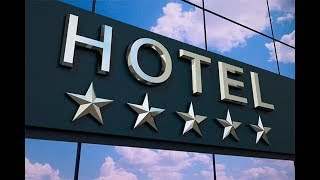

In [147]:
from IPython.display import Image
Image("image/hotel.jpeg", width=900)


# Hotel Chain Cancellation Rating

## Problema de negócio:

A rede hoteleira espanhola Costa del Data, está com uma alta demanda de cancelamentos de reservas.

A suspeita da diretoria é de que houve uma mudança no comportamento de cancelamentos por parte do consumidor após a pandemia, que ainda não foi compreendida pela rede.

Para compreender esse fenômeno, nós "Only Outliers" fomos contratamos para desenvolver um modelo de previsão de cancelamentos afim de auxiliar o time de marketing tomar decisões mais assertivas.

Questão de negócio:

Para obter respostas relevantes do modelo de ML, é importante formular boas perguntas relacionadas ao negócio. Aqui estão algumas perguntas que podem ajudar a direcionar o trabalho do modelo:

        - 1. Qual é a probabilidade de um cliente cancelar uma reserva com base em seu histórico de reservas anteriores?

        - 2. Existem determinados tipos de quartos que apresentam maior taxa de cancelamento de reservas do que outros?

        - 3. Existe alguma sazonalidade na taxa de cancelamento de reservas? Por exemplo, a taxa de cancelamento é maior durante os meses de verão?

        - 4. Há algum perfil de cliente que apresenta maior probabilidade de cancelar uma reserva? Por exemplo, clientes que reservam com pouca antecedência ou que reservam por meio de canais de terceiros?

        - 5. Existe alguma interação entre diferentes variáveis que possa influenciar a probabilidade de cancelamento de reservas? Por exemplo, a probabilidade de cancelamento é afetada pela duração da estadia ou pelo preço do quarto?

        - 6. É possível identificar os clientes que apresentam maior probabilidade de cancelar uma reserva com antecedência, permitindo que a empresa tome medidas para evitar esses cancelamentos?



Entre os clientes que fizeram reservas, quais irão cancelar?

Relatório com melhores insights de negócio.

Tópicos mais relevantes

A importância da EDA durante a produção projeto.

Insights de negócio.

Utilização de Pipelines para organizar a solução.

Avaliação do modelo.

Os cincos melhores modelos para gerar o modelo final.


# 0.0 Imports

In [148]:
import inflection
import io
import math
import time
import random
import numpy as np
import pandas as pd
import seaborn as snb
import time
import sweetviz as sv
import warnings

from xgboost import XGBClassifier
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import tree
from boruta import BorutaPy

from category_encoders import CountEncoder, TargetEncoder
from imblearn.over_sampling import RandomOverSampler



%matplotlib inline
snb.set_style('whitegrid')
warnings.filterwarnings('ignore')


## Functions

In [149]:
def show_dtypes(df):
    print(df.dtypes)
    return None

def show_dimensions(df):
    print('Number of rows: {}' .format(df.shape[0]))
    print('Number of columns: {}' .format(df.shape[1]))
    return None

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return round(np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) ),2)

# 1.0 Loading Data

In [150]:
df_train = pd.read_csv('dataset/train.csv')
df_test  = pd.read_csv('dataset/test.csv')
sub_m = pd.read_csv('dataset/submission.csv')

### Data Description

In [151]:
df = df_train.copy()

In [152]:
# Verificando as estatísticas básicas do conjunto de dados
df.describe()


,id,Meses da reserva até o check-in,Número de pernoites reservadas,Número de hospedes,Reserva Cancelada
count,72159.000000,72159.000000,72159.000000,72156.000000,72159.000000
mean,60093.687787,7.145928,15.824152,14.258773,0.370418
std,34726.028006,25.852330,98.248479,96.446167,0.482920
min,1.000000,1.000000,0.000000,0.000000,0.000000
25%,30013.500000,1.000000,2.000000,2.000000,0.000000
50%,60080.000000,3.000000,3.000000,2.000000,0.000000
75%,90301.000000,6.000000,4.000000,2.000000,1.000000
max,120265.000000,311.000000,1172.000000,1153.000000,1.000000


In [153]:
# Obter informações gerais sobre o dataframe, Algumas variáveis são numéricas, enquanto outras são categóricas.
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72159 entries, 0 to 72158
Data columns (total 15 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    72159 non-null  int64  
 1   Classificação do hotel                72159 non-null  object 
 2   Meses da reserva até o check-in       72159 non-null  int64  
 3   Número de pernoites reservadas        72159 non-null  int64  
 4   Número de hospedes                    72156 non-null  float64
 5   Regime de alimentação                 72159 non-null  object 
 6   Nacionalidade                         71066 non-null  object 
 7   Forma de Reserva                      72159 non-null  object 
 8   Já se hospedou anterioremente         72159 non-null  object 
 9   Tipo do quarto reservado              72159 non-null  object 
 10  Reserva feita por agência de turismo  72159 non-null  object 
 11  Reserva feita p

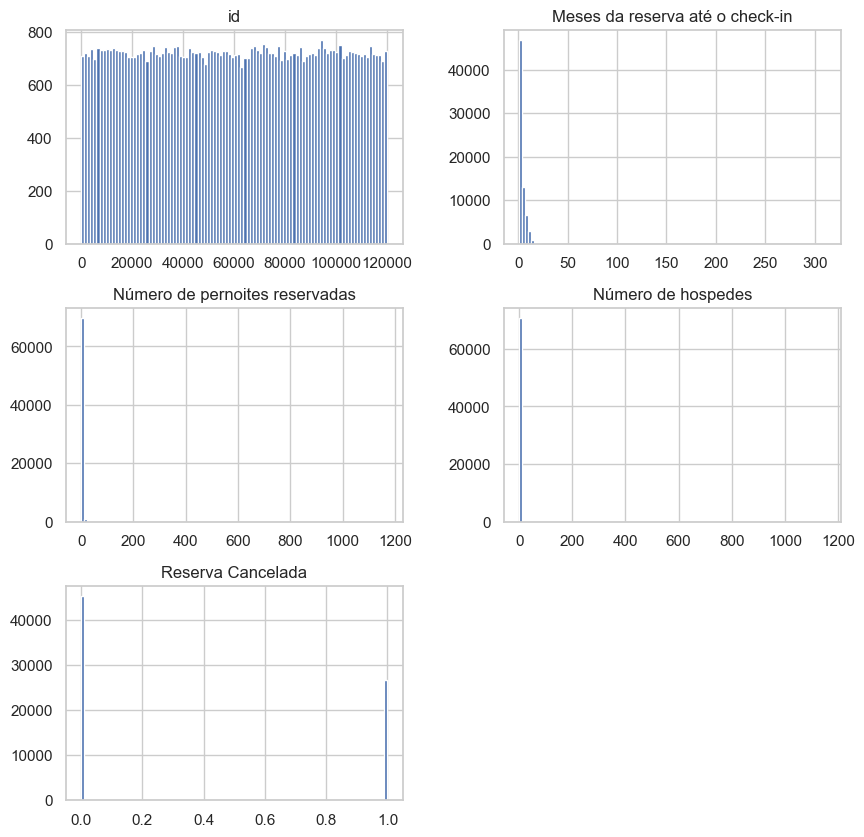

In [154]:
# Para visualizar a distribuição das variáveis numéricas, podemos utilizar o histograma

plt.rcParams['figure.figsize'] = [10,10]
num_attributes = df.select_dtypes( include= ['float64', 'int64'] )
num_attributes.hist( bins= 100);

## Rename columns

In [155]:
df = df.rename(columns={'Classificação do hotel': 'hotel_rating', 'Meses da reserva até o check-in': 'month_booking',
                        'Número de pernoites reservadas': 'number_stays_booking', 'Número de hospedes': 'number_guests',
                        'Regime de alimentação': 'meal_regime', 'Nacionalidade': 'nationality', 'Forma de Reserva': 'reservation_Form',
                        'Já se hospedou anterioremente': 'previously_hosted', 'Tipo do quarto reservado': 'type_booked_room',
                        'Reserva feita por agência de turismo': 'tourism_agency_booking', 'Reserva feita por empresa': 'company_booking',
                        'Reserva com Estacionamento': 'parking_Reservation', 'Reserva com Observações': 'reservation_Observations', 'Reserva Cancelada': 'booking_canceled'})


## 1.3 Data Dimension

In [156]:
# verificando o tamanho do conjunto de dados
show_dimensions(df)

Number of rows: 72159
Number of columns: 15


### Dtypes

In [157]:
show_dtypes(df)

id                            int64
hotel_rating                 object
month_booking                 int64
number_stays_booking          int64
number_guests               float64
meal_regime                  object
nationality                  object
reservation_Form             object
previously_hosted            object
type_booked_room             object
tourism_agency_booking       object
company_booking              object
parking_Reservation          object
reservation_Observations     object
booking_canceled              int64
dtype: object


## 1.4 Check NaN 

In [158]:
# Verificando a presença de valores nulos
df.isna().sum()#/len(df)

id                             0
hotel_rating                   0
month_booking                  0
number_stays_booking           0
number_guests                  3
meal_regime                    0
nationality                 1093
reservation_Form               0
previously_hosted              0
type_booked_room               0
tourism_agency_booking         0
company_booking                0
parking_Reservation            0
reservation_Observations       0
booking_canceled               0
dtype: int64

### Fill drop Na

In [159]:
#df.dropna(inplace=True)
df['nationality'] = df['nationality'].apply(
    lambda x: 'nao_identificado' if pd.isnull(x) else x)

df['number_guests'] = df['number_guests'].apply(
    lambda x: 1 if pd.isnull(x) else x)


In [160]:
df.isna().sum()

id                          0
hotel_rating                0
month_booking               0
number_stays_booking        0
number_guests               0
meal_regime                 0
nationality                 0
reservation_Form            0
previously_hosted           0
type_booked_room            0
tourism_agency_booking      0
company_booking             0
parking_Reservation         0
reservation_Observations    0
booking_canceled            0
dtype: int64

In [161]:
# Verificar valores duplicados
df.duplicated().sum()

0

In [162]:
df.isna().sum()#/len(df)

id                          0
hotel_rating                0
month_booking               0
number_stays_booking        0
number_guests               0
meal_regime                 0
nationality                 0
reservation_Form            0
previously_hosted           0
type_booked_room            0
tourism_agency_booking      0
company_booking             0
parking_Reservation         0
reservation_Observations    0
booking_canceled            0
dtype: int64

### Change Type

In [163]:
df['id'] = df['id'].astype('int64')



## 1.6. Data Balancing

In [164]:
df['booking_canceled'].value_counts(normalize=True)


0    0.629582
1    0.370418
Name: booking_canceled, dtype: float64

# EDA - Exploratory Data Analysis

In [165]:
df1 = df.copy()

In [166]:


# Gerando o relatório completo de análise exploratória de dados
report = sv.analyze(df1)

# Salvando o relatório em HTML
report.show_html('report.html')


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)


Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Gráfico de barras: para visualizar a distribuição das variáveis categóricas

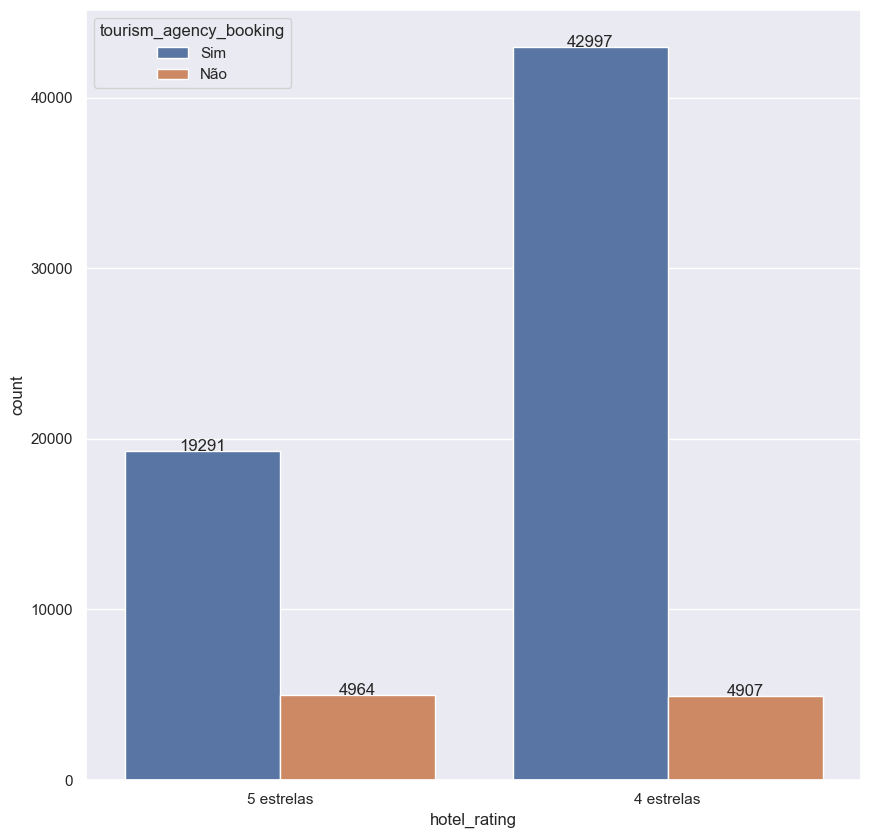

In [167]:

sns.set(style="darkgrid")

# Plotando o gráfico de barras com a contagem
ax = sns.countplot(x="hotel_rating",
                   hue="tourism_agency_booking", data=df1)

# Adicionando o valor da contagem em cima de cada barra
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+3,
            '{:.0f}'.format(height), ha="center")

plt.show()


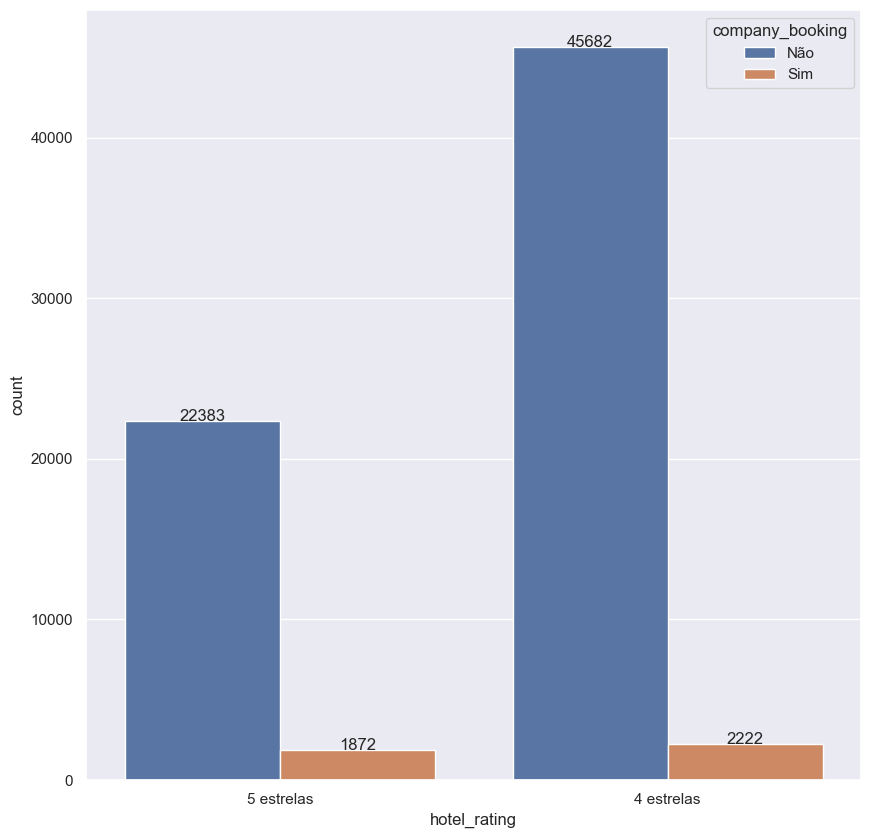

In [168]:
sns.set(style="darkgrid")

# Plotando o gráfico de barras com a contagem
ax = sns.countplot(x="hotel_rating",
                   hue="company_booking", data=df)

# Adicionando o valor da contagem em cima de cada barra
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+3,
            '{:.0f}'.format(height), ha="center")

plt.show()


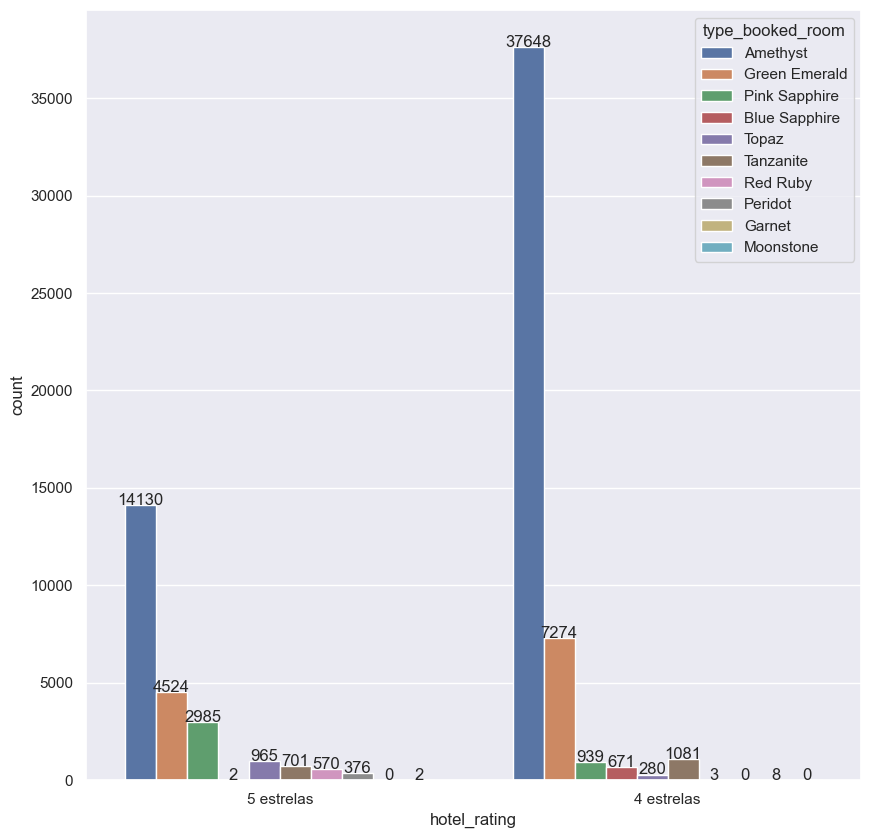

In [169]:


# Plotando o gráfico de barras com a contagem
ax = sns.countplot(x="hotel_rating",
                   hue="type_booked_room", data=df1)

# Adicionando o valor da contagem em cima de cada barra
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+3,
            '{:.0f}'.format(height), ha="center")
sns.set(style="darkgrid")
plt.show()


In [170]:
percent = df.groupby('booking_canceled')['id'].count().reset_index()
percent['Percent'] = percent['id']/df1.shape[0]
percent.rename(columns={'id': 'Total'}, inplace=True)
percent


,booking_canceled,Total,Percent
0,0,45430,0.629582
1,1,26729,0.370418


## Multivariate Analysis

<AxesSubplot:>

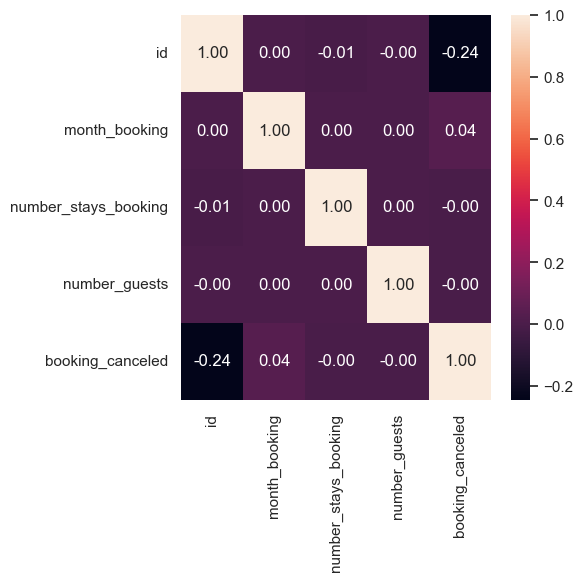

In [171]:
# Numerical Variables
plt.rcParams['figure.figsize'] = [5, 5]
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
corr = num_attributes.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt='.2f')


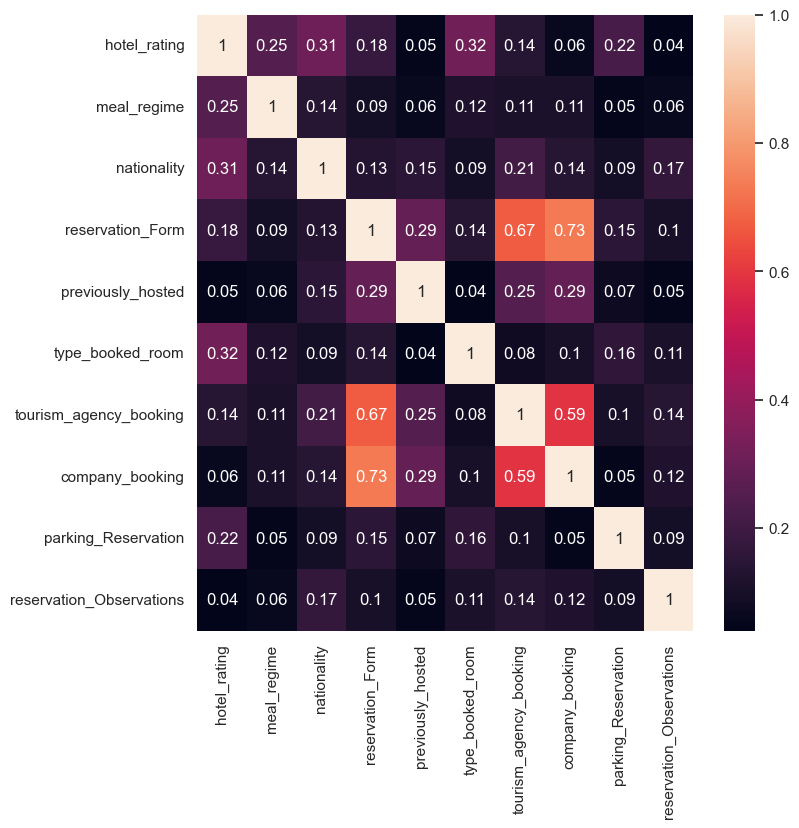

In [172]:
# Categorical Variables
plt.rcParams['figure.figsize'] = [8,8]
cat_attributes = df1.select_dtypes(include='object')
lista=[]
for col in cat_attributes.columns:
    lista2 =[]
    for col2 in cat_attributes.columns:
        lista2.append(cramer_v(cat_attributes[col], cat_attributes[col2]))
    lista.append(lista2)
cramer = pd.DataFrame(lista,columns=cat_attributes.columns,index=cat_attributes.columns)
sns.heatmap(cramer,annot=True);

### Data Praration

In [173]:
df2 = df1.copy()

### Rescaling

In [174]:
rs = RobustScaler()

# meses_da_reserva_ate_o_check-in - Robust Scaler
df2['id'] = rs.fit_transform( df2[['id']].values )

# meses_da_reserva_ate_o_check-in - Robust Scaler
df2['month_booking'] = rs.fit_transform(df2[['month_booking']].values)

# numero_de_pernoites_reservadas - Robust Scaler
df2['number_stays_booking'] = rs.fit_transform( df2[['number_stays_booking']].values )

# numero_de_hospedes - Robust Scaler
df2['number_guests'] = rs.fit_transform( df2[['number_guests']].values )

In [175]:
# meses ate o chekin da reserva
df2[df2['month_booking']>24].sample(2)
df2[df2['month_booking'] > 60][['id', 'booking_canceled']
                             ].groupby('booking_canceled').count().reset_index()

# numero_de_pernoites_reservadas
df2[df2['number_stays_booking']>365].sample(10)
df2[df2['number_stays_booking']>365][['id','booking_canceled']].groupby('booking_canceled').count().reset_index()
df2[df2['number_stays_booking']>365][['id','booking_canceled']].groupby('booking_canceled').count().reset_index()

,booking_canceled,id
0,0,375
1,1,209


In [176]:
# numero_de_pernoites_reservadas
df2[df2['number_stays_booking']>365].sample(10)
df2[df2['number_stays_booking']>365][['id','booking_canceled']].groupby('booking_canceled').count().reset_index()
df2[df2['number_stays_booking']>365][['id','booking_canceled']].groupby('booking_canceled').count().reset_index()

,booking_canceled,id
0,0,375
1,1,209


In [177]:
df2[df2['number_stays_booking']==0][['id','booking_canceled']].groupby('booking_canceled').count().reset_index()

,booking_canceled,id
0,0,9326
1,1,6629


In [178]:
df2[df2['number_guests'] > 10][['id',  'company_booking']
                               ].groupby('company_booking').count().reset_index()


,company_booking,id
0,Não,1375
1,Sim,87


In [179]:
df2[df2['number_guests'] == 0][['id', 'tourism_agency_booking',]
                               ].groupby('tourism_agency_booking').count().reset_index()


,tourism_agency_booking,id
0,Não,4633
1,Sim,43961


### Transformacao

In [180]:
df3 = df2.copy()

In [181]:
# # classificacao_do_hotel
# df4['hotel_rating'] = df4['hotel_rating'].apply(lambda x: int(x.split('estrela')[1]))

# # ja_se_hospedou_anterioremente
# df4['previously_hosted'] = df4['previously_hosted'].apply(
#     lambda x: x.replace('Sim', '1'))
# df4['previously_hosted'] = df4['previously_hosted'].apply(
#     lambda x: x.replace('Não', '0'))

# # reserva_feita_por_agencia_de_turismo
# df4['tourism_agency_booking'] = df4['tourism_agency_booking'].apply(
#     lambda x: x.replace('Sim', '1'))
# df4['tourism_agency_booking'] = df4['tourism_agency_booking'].apply(
#     lambda x: x.replace('Não', '0'))

# # reserva_com_estacionamento
# df4['parking_Reservation'] = df4['parking_Reservation'].apply(
#     lambda x: x.replace('Sim', '1'))
# df4['parking_Reservation'] = df4['parking_Reservation'].apply(
#     lambda x: x.replace('Não', '0'))

# # reserva_feita_por_empresa
# df4['company_booking'] = df4['company_booking'].apply(
#     lambda x: x.replace('Sim', '1'))
# df4['company_booking'] = df4['company_booking'].apply(
#     lambda x: x.replace('Não', '0'))


In [182]:
df3['meal_regime'].unique()


array(['Café da manha e jantar', 'Café da manha', 'Sem refeicao',
       'Café da manha, almoco e jantar'], dtype=object)

In [183]:
# Label Encoder
le = LabelEncoder()
label_cols = ['meal_regime', 'nationality', 'reservation_Form', 'type_booked_room', 'reservation_Observations']
for col in label_cols:
    df3[col] = le.fit_transform(df3[col])

# Ordinal Encoding
classificacao_dict = {'5 estrelas': 5, '4 estrelas': 4}
df3['hotel_rating'] = df3['hotel_rating'].map(classificacao_dict)

# Boolean
bool_cols = ['previously_hosted','tourism_agency_booking','company_booking','parking_Reservation']
for col in bool_cols:
    df3[col] = df3[col].apply(
        lambda x: 0 if x == 'Não' else 1 if x == 'Sim' else x)


In [184]:

# transform into int
df3['hotel_rating'] = df3['hotel_rating'].astype('int')
df3['previously_hosted'] = df3['previously_hosted'].astype('int')
df3['tourism_agency_booking'] = df3['tourism_agency_booking'].astype('int')
df3['company_booking'] = df3['company_booking'].astype('int')
df3['parking_Reservation'] = df3['parking_Reservation'].astype('int')


# Feature Selection

In [185]:
df5 = df3.copy()


# imputar os valores faltantes com a média
df5.fillna(df5.mean(), inplace=True)


In [186]:
# Split Train Test Dataset

X = df5.drop(columns=['booking_canceled'])
y = df5[['booking_canceled']]


In [187]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [188]:
# criar objeto RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# realizar o upsampling na base de treino
X_train, y_train = oversampler.fit_resample( X_train, y_train )

### Boruta as Feature Selector

In [189]:
#define RandomForestRegressor
clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)

# define Boruta
boruta = BorutaPy(clf, n_estimators='auto',verbose=2,random_state=0).fit(X_train.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	8


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	8


## Best Features from Boruta

In [190]:
cols_selected_boruta = boruta.support_.tolist()
cols_selected_boruta = X_train.iloc[:,cols_selected_boruta].columns.tolist()

## Manual Features

In [191]:
cols_selected_boruta


['id',
 'hotel_rating',
 'month_booking',
 'nationality',
 'parking_Reservation',
 'reservation_Observations']

In [192]:
# cols_selected_boruta = ['id',
#                        'classificacao_do_hotel',
#                        'meses_da_reserva_ate_o_check_in',
#                        'nacionalidade',
#                        'reserva_com_estacionamento',
#                        'reserva_com_observacoes']


#  Machine Learning Model

In [193]:
# x_train = X_train[cols_selected_boruta]
# x_test  = X_test[cols_selected_boruta]

x_train = X_train.copy()
x_test = X_test.copy()


### KNN

In [194]:
# model definition
result_list = []

# Choose k number
for k in range(3, 15):

    knn_model = KNeighborsClassifier(n_neighbors=k)

    # model training
    knn_model.fit(x_train, y_train)

    # model classifier
    y_pred = knn_model.predict(x_test)

    # performance
    f_score_knn = f1_score(y_test, y_pred, average='macro')

    result_list.append({"k": k, "f_score": f_score_knn})

# K with highest score
k = max(result_list, key=lambda x: x['f_score'])['k']
f_score_knn = max(result_list, key=lambda x: x['f_score'])['f_score']
print(f"K = {k}\nF-Score = {f_score_knn:.2%}")


K = 4
F-Score = 85.46%


### 6.1. XGBoost

In [195]:
# model definition
xgb_model = GradientBoostingClassifier(
    n_estimators=1500, max_depth=10, subsample=0.8)

# model training
xgb_model.fit(x_train, y_train)

# model classifier
y_pred_xgb = xgb_model.predict(x_test)


### Xgboost Performae 

In [196]:
# performance
f_score_xgb = f1_score( y_test, y_pred_xgb, average= 'macro')

print( f'F-score XGBoost: {f_score_xgb:.2%}' )

F-score XGBoost: 96.91%


## Categorical Boost (Cat Boost)

In [197]:
# model definition
cat_model = CatBoostClassifier(iterations=1000, learning_rate=0.2)

# model training
cat_model.fit(x_train, y_train, verbose=False)


# model classifier
y_pred_cat = cat_model.predict(x_test)


In [198]:
# performance
f_score_cat = f1_score( y_test, y_pred_cat, average= 'macro')

print( f'F-score CatBoost: {f_score_cat:.2%}' )

F-score CatBoost: 96.52%


### 6.2. Logistic Regression

In [199]:
# model definition
lr_model = LogisticRegression()

# model training
lr_model.fit(x_train, y_train)

# model classifier
y_pred_lr = lr_model.predict(x_test)


In [200]:
# performance
f_score_lr = f1_score( y_test, y_pred_lr, average= 'macro')
print( f'F-score knn: {f_score_lr:.2%}' )

F-score knn: 72.82%


In [201]:
# Naive Bayes

In [202]:
# model definition
nb_model = GaussianNB()

# model training
nb_model.fit(x_train, y_train)

# model classifier
y_pred_nb = nb_model.predict(x_test)


In [203]:
# performance
f_score_nb = f1_score( y_test, y_pred_nb, average= 'macro')

print( f'F-score Naive Bayes: {f_score_nb:.2%}' )

F-score Naive Bayes: 48.12%


## Decision Tree

In [204]:
# Crie uma instância do classificador de árvore de decisão
clf = tree.DecisionTreeClassifier()

# Treine o classificador usando os dados de treinamento
clf.fit(x_train, y_train)

# Faça previsões usando o conjunto de teste
y_pred_clf = clf.predict(x_test)


In [205]:
# performance
f_score_clf = f1_score( y_test, y_pred_clf, average= 'macro')

print( f'F-score Decision Tree: {f_score_clf:.2%}' )

F-score Decision Tree: 96.14%


# XGBoost Hyperparameter Fine Tuning


In [206]:
t_start = time.time()
print('Start:',datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))

Start: 04-04-2023 22:27:56


In [208]:
param = {'learning_rate': [0.01, 0.05, 0.1],
         'max_depth': [3, 4, 5, 10],
         'n_estimators': [100, 500, 1000],
         'subsample': [0.1, 0.3, 0.8]}
# Calculate weights

# y array of weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y)

# dict of weights
n_classes = len(np.unique(y))
weight_0 = len(y) / (n_classes * y.value_counts()[0])
weight_1 = len(y) / (n_classes * y.value_counts()[1])
class_weights = {0: weight_0, 1: weight_1}

# use RandomizedSearchCV to find the best hyperparameter combination.
random_search = RandomizedSearchCV(GradientBoostingClassifier(),
                                   param_distributions=param,
                                   cv=5,
                                   n_iter=20,
                                   scoring='f1_macro',
                                   random_state=32,
                                   n_jobs=-1)
random_search.fit(X.values, y.values, sample_weight=sample_weights)

# print the best hyperparameter combination and its F-score (macro).
print("Best hyperparameter:", random_search.best_params_)
print(f"Best F-score (macro): {random_search.best_score_:.2%}")


/Users/hallanmiranda/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hallanmiranda/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hallanmiranda/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hallanmiranda/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A 

Best hyperparameter: {'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.1}
Best F-score (macro): 97.08%


In [209]:



duration = time.time()-t_start
h = '{:02d}'.format(int(duration//3600))
m = '{:02d}'.format(int((duration % 3600)//60))
s = '{:02d}'.format(int(duration % 60))

print('End:', datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))
print(f'Fine tuning execution time: {h}:{m}:{s}')


End: 05-04-2023 00:25:25
Fine tuning execution time: 01:57:29


## 6.4. Random Forest

In [210]:
# model definition
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# model training
rf_model.fit(x_train, y_train)

# model classifier
y_pred_rf = rf_model.predict(x_test)


In [211]:
# performance
f_score_rf = f1_score( y_test, y_pred_rf, average= 'macro')

print( f'F-score Random Forest: {f_score_rf:.2%}' )

F-score Random Forest: 96.76%


## Categorical Boost (Cat Boost)

In [212]:
# model definition
cat_model = CatBoostClassifier(iterations=1000, learning_rate=0.2)

# model training
cat_model.fit(x_train, y_train, verbose=False)


# model classifier
y_pred_cat = cat_model.predict(x_test)


# Final Model

In [221]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier

np.seterr(all='ignore')


param = random_search.best_params_

# model definition
xgb_model = GradientBoostingClassifier(subsample=param['subsample'],
                                       n_estimators=param['n_estimators'],
                                       max_depth=param['max_depth'],
                                       learning_rate=param['learning_rate'],
                                       random_state=42)

# model training
xgb_model.fit(X.values, y.values, sample_weight=sample_weights)
xgb_model.fit( x_train, y_train )


GradientBoostingClassifier(max_depth=10, n_estimators=1000, random_state=42,
                           subsample=0.8)

# Predict Kaggle Submission Data

In [222]:
df_test = pd.read_csv('dataset/test.csv', low_memory=False)
_id = df_test['id']


In [223]:
dft = df_test.copy()

## Rename Columns

In [224]:
# Rename 
dft = df_test.rename(columns={'Classificação do hotel': 'hotel_rating', 'Meses da reserva até o check-in': 'month_booking',
                        'Número de pernoites reservadas': 'number_stays_booking', 'Número de hospedes': 'number_guests',
                        'Regime de alimentação': 'meal_regime', 'Nacionalidade': 'nationality', 'Forma de Reserva': 'reservation_Form',
                        'Já se hospedou anterioremente': 'previously_hosted', 'Tipo do quarto reservado': 'type_booked_room',
                        'Reserva feita por agência de turismo': 'tourism_agency_booking', 'Reserva feita por empresa': 'company_booking',
                        'Reserva com Estacionamento': 'parking_Reservation', 'Reserva com Observações': 'reservation_Observations', 'Reserva Cancelada': 'booking_canceled'})




## Fill NA

In [225]:
dft['nationality'] = dft['nationality'].apply(
    lambda x: 'nao_identificado' if pd.isnull(x) else x)
dft['number_guests'] = dft['number_guests'].apply(
    lambda x: 1 if pd.isnull(x) else x)
dft['number_guests'] = dft['number_guests'].astype('int64')


## Change type

In [226]:
dft['id'] = dft['id'].astype('int64')
dft['number_guests'] = dft['number_guests'].astype('int64')


## Rescaling

In [227]:
rs = RobustScaler()

# meses_da_reserva_ate_o_check-in - Robust Scaler
dft['id'] = rs.fit_transform( dft[['id']].values )

# meses_da_reserva_ate_o_check-in - Robust Scaler
dft['month_booking'] = rs.fit_transform(dft[['month_booking']].values)

# numero_de_pernoites_reservadas - Robust Scaler
dft['number_stays_booking'] = rs.fit_transform( dft[['number_stays_booking']].values )

# numero_de_hospedes - Robust Scaler
dft['number_guests'] = rs.fit_transform( dft[['number_guests']].values )

## Transformation

In [228]:
 # Label Encoder
le = LabelEncoder()
label_cols = ['meal_regime', 'nationality', 'reservation_Form',
              'type_booked_room', 'reservation_Observations']
for col in label_cols:
    dft[col] = le.fit_transform(dft[col])

# Ordinal Encoding
classificacao_dict = {'5 estrelas': 5, '4 estrelas': 4}
dft['hotel_rating'] = dft['hotel_rating'].map(classificacao_dict)

# Boolean
bool_cols = ['previously_hosted', 'tourism_agency_booking',
             'company_booking', 'parking_Reservation']
for col in bool_cols:
    dft[col] = dft[col].apply(
        lambda x: 0 if x == 'Não' else 1 if x == 'Sim' else x)



In [229]:
# transform into int
dft['hotel_rating'] = dft['hotel_rating'].astype('int')
dft['previously_hosted'] = dft['previously_hosted'].astype('int')
dft['tourism_agency_booking'] = dft['tourism_agency_booking'].astype('int')
dft['company_booking'] = dft['company_booking'].astype('int')
dft['parking_Reservation'] = dft['parking_Reservation'].astype('int')

## Predict

In [230]:
y_pred_test = xgb_model.predict(dft.values)
submission = pd.concat([_id, pd.Series(y_pred_test, name='Reserva Cancelada')], axis=1)


## Create submission file

In [231]:
submission.to_csv('submission.csv', index=False)


In [232]:
percent2 = submission.groupby('Reserva Cancelada')['id'].count().reset_index()
percent2['Percent'] = percent2['id']/submission.shape[0]
percent2.rename(columns={'id': 'Total'}, inplace=True)
percent2


,Reserva Cancelada,Total,Percent
0,0,33327,0.692783
1,1,14779,0.307217
